In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn import datasets
from sklearn.model_selection import ParameterGrid
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering

from scipy.spatial import distance_matrix

In [13]:
def run_clustering_1(algorithm, data, name):
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,15))
    for (clusters, ax_idx) in zip(range(3,9), range(0,6)):
        res = algorithm(n_clusters=clusters).fit_predict(data)
        ax = axes[ax_idx//2, ax_idx%2]
        ax.scatter(data[:,0], data[:,1], c=res, cmap="Set1")
        ax.set_title(f"{name} clusters={clusters}")

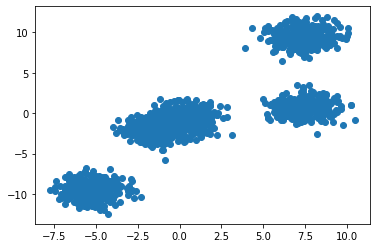

In [4]:
n_samples = 1500
np.random.seed(0)
convex_blobs = datasets.make_blobs(n_samples=n_samples, random_state=8, centers=5, cluster_std=1)
convex_blobs=convex_blobs[0]

plt.scatter(convex_blobs[:,0], convex_blobs[:,1])

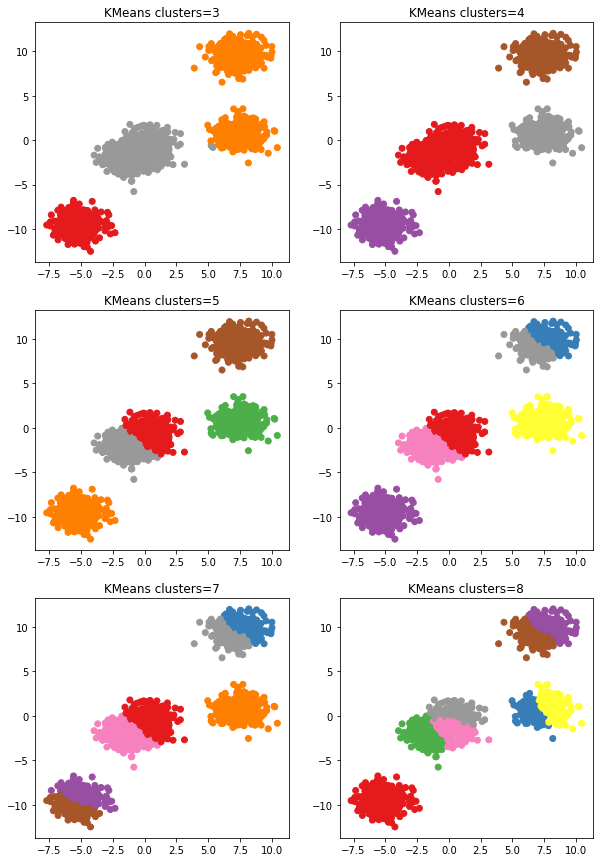

In [14]:
run_clustering_1(KMeans, convex_blobs, "KMeans")

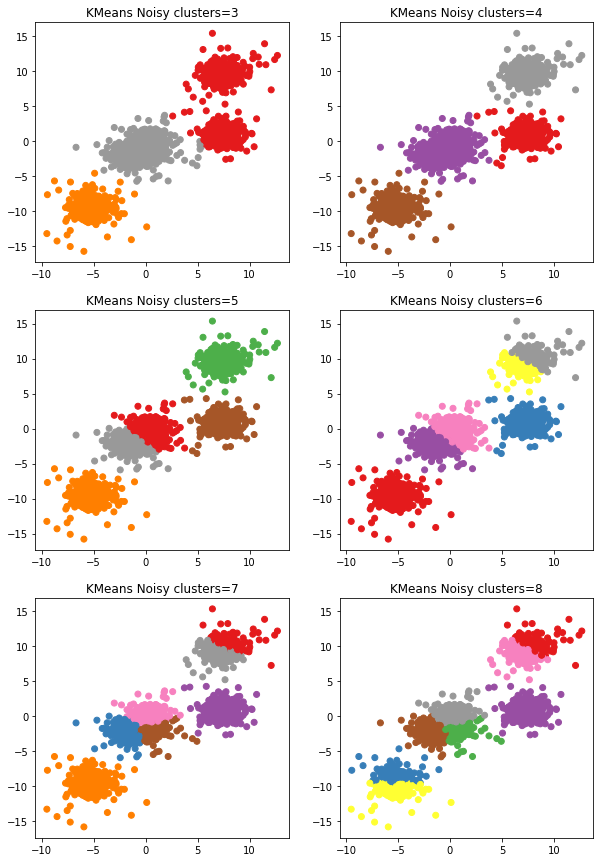

In [15]:
idxs = np.arange(n_samples)
np.random.shuffle(idxs)

shift = (np.random.rand(*convex_blobs.shape)*8 - 4)
shift[idxs[150:],:] = 0
convex_blobs_noisy = convex_blobs - shift


run_clustering_1(KMeans, convex_blobs_noisy, "KMeans Noisy")

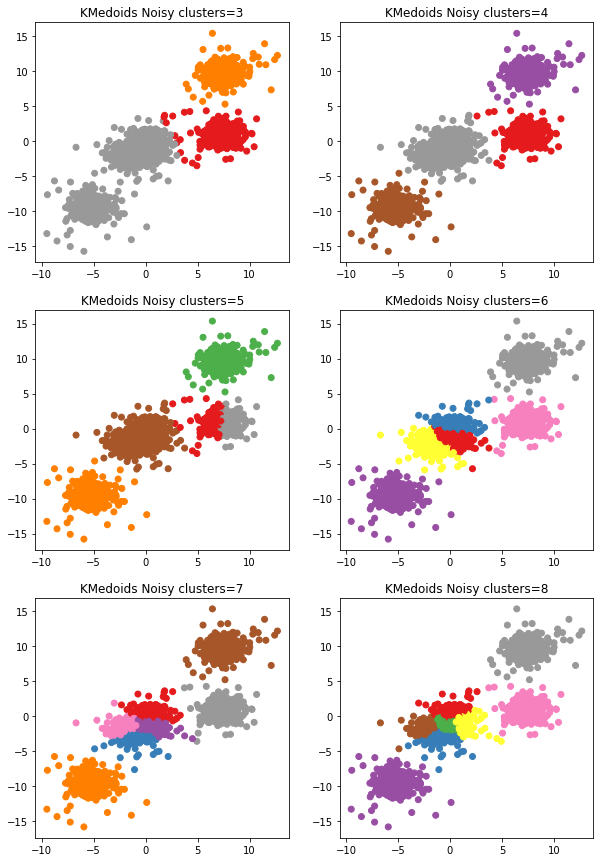

In [16]:
run_clustering_1(KMedoids, convex_blobs_noisy, "KMedoids Noisy")

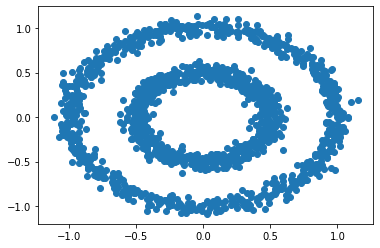

In [17]:
circles = datasets.make_circles(n_samples=n_samples, noise=0.05, factor=0.5)
circles = circles[0]

plt.scatter(circles[:,0], circles[:,1])

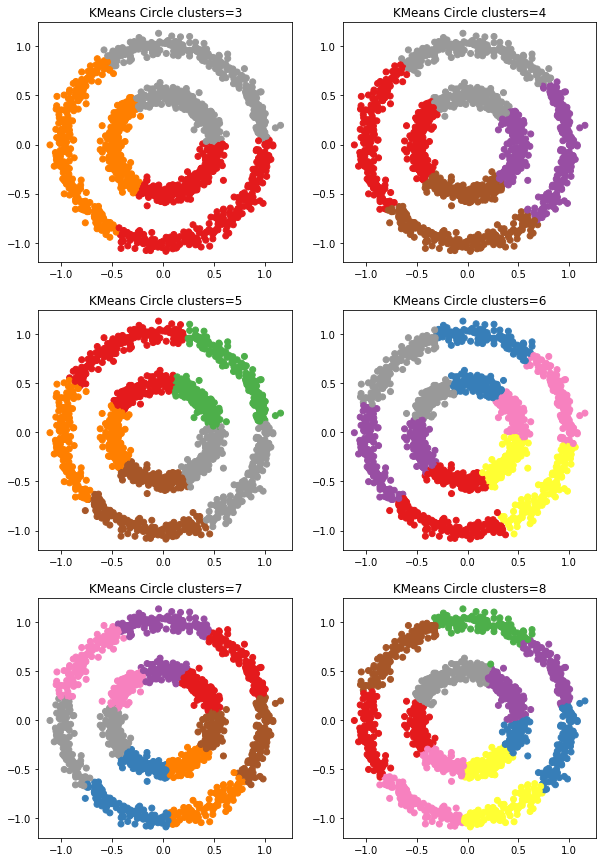

In [18]:
run_clustering_1(KMeans, circles, "KMeans Circle")

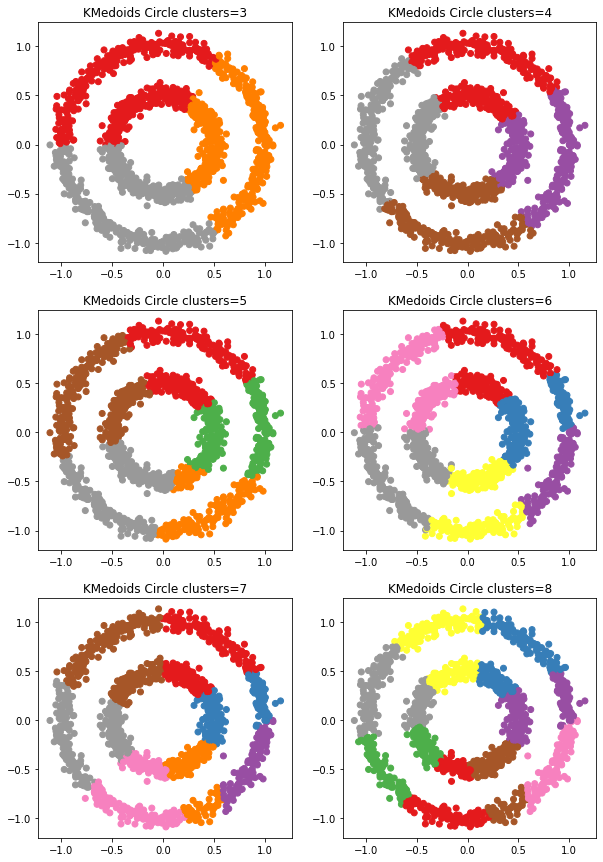

In [19]:
run_clustering_1(KMedoids, circles, "KMedoids Circle")

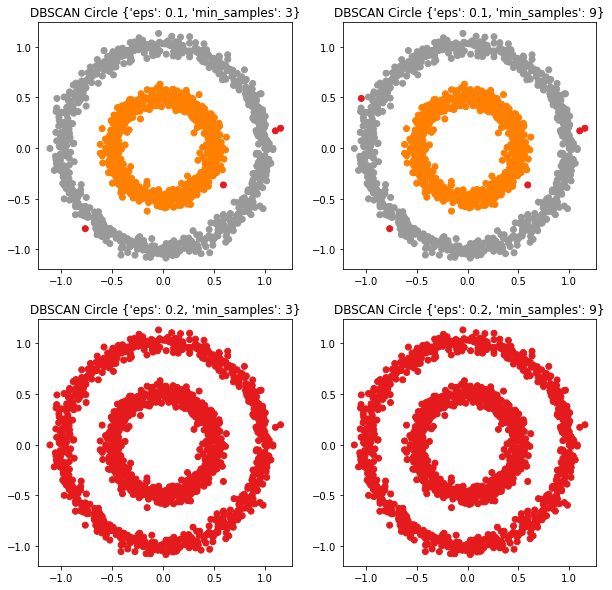

In [23]:
parameters = {'min_samples': [3, 9], 'eps': [0.1, 0.3]}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax_idx = 0
for combination in ParameterGrid(parameters):
    res = DBSCAN(**combination).fit_predict(circles)
    ax = axes[ax_idx//2, ax_idx%2]
    ax.scatter(circles[:,0], circles[:,1], c=res, cmap="Set1")
    ax.set_title(f"DBSCAN Circle {combination}")
    ax_idx += 1

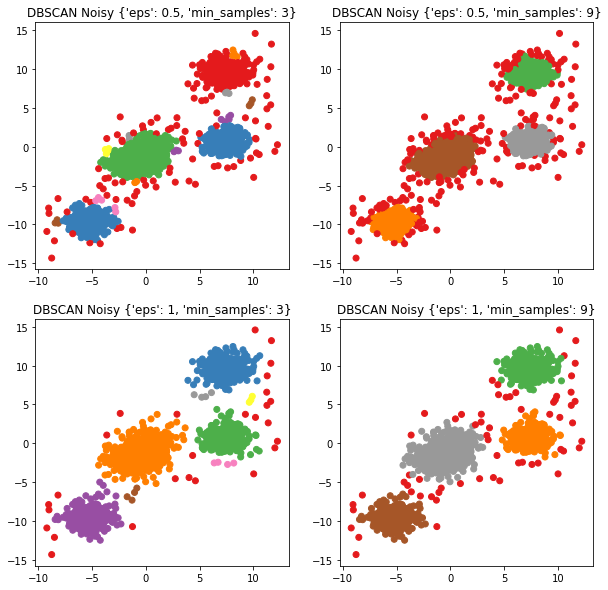

In [339]:
parameters = {'min_samples': [3,9], 'eps': [0.5, 1]}

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
ax_idx = 0
for combination in ParameterGrid(parameters):
    res = DBSCAN(**combination).fit_predict(convex_blobs_noisy)
    ax = axes[ax_idx//2, ax_idx%2]
    ax.scatter(convex_blobs_noisy[:,0], convex_blobs_noisy[:,1], c=res, cmap="Set1")
    ax.set_title(f"DBSCAN Noisy {combination}")
    ax_idx += 1

In [32]:
from scipy.cluster.hierarchy import dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


def run_clustering_agglomerative(linkage, p=4):
    model = AgglomerativeClustering(n_clusters=5, linkage=linkage, compute_distances=True)
    res = model.fit_predict(convex_blobs_noisy)

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,6))
    plot_dendrogram(model, ax=axes[0], truncate_mode='level', p=p)
    ax = axes[1]
    ax.scatter(convex_blobs_noisy[:,0], convex_blobs_noisy[:,1], c=res, cmap="Set1")
    fig.suptitle(f"Agglomerative {linkage}", fontsize=16)



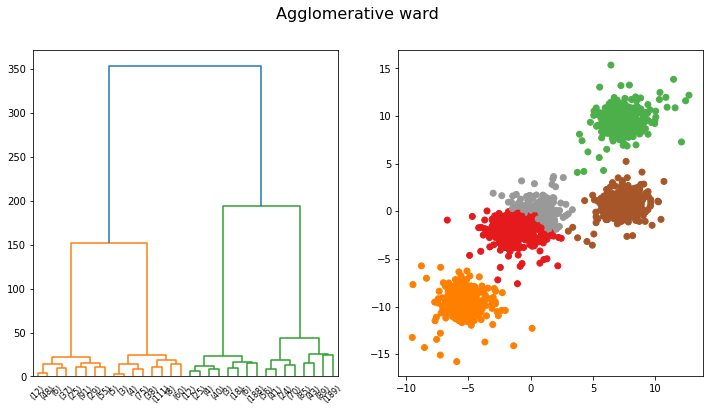

In [33]:
run_clustering_agglomerative("ward")

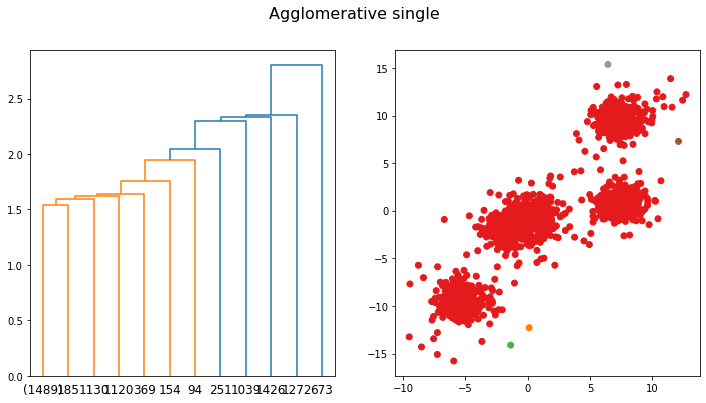

In [35]:
run_clustering_agglomerative("single", p=10)

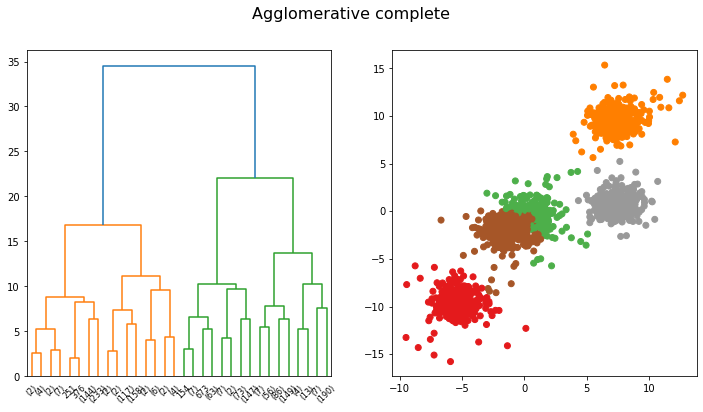

In [36]:
run_clustering_agglomerative("complete")

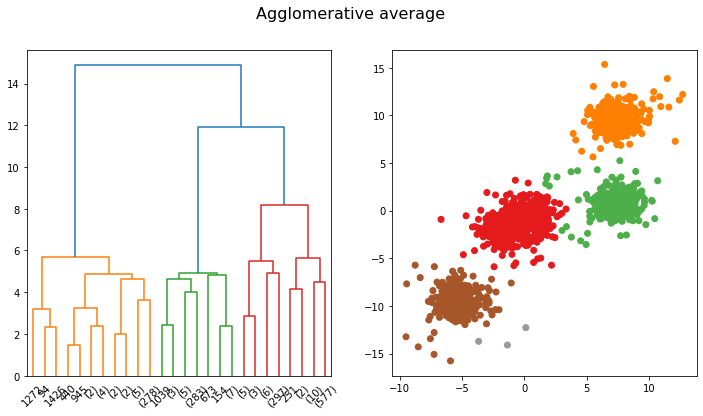

In [38]:
run_clustering_agglomerative("average")

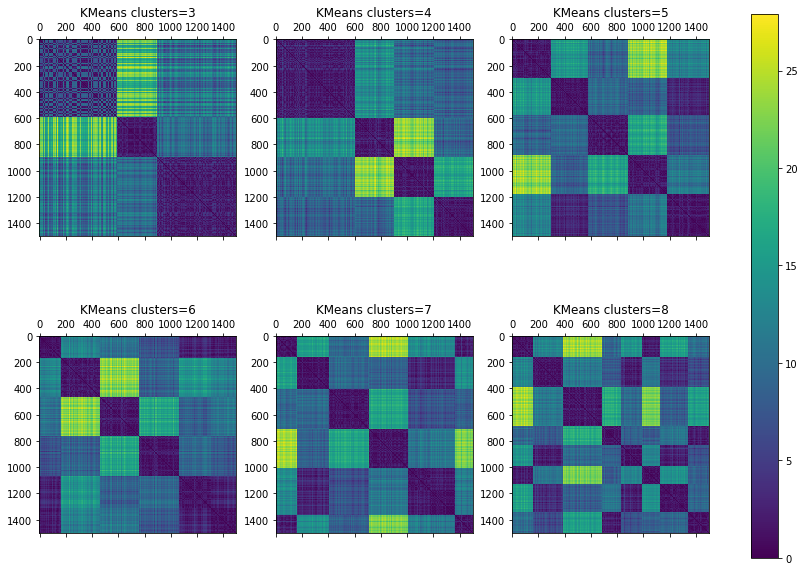

In [345]:
def plot_distance_matrix(points, clusters, ax):
    idxs = clusters.argsort()
    points = points[idxs]
    distances = distance_matrix(points, points)
    return ax.matshow(distances)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
for (clusters, ax_idx) in zip(range(3,9), range(0,6)):
    res = KMeans(n_clusters=clusters).fit_predict(convex_blobs)
    ax = axes[ax_idx//3, ax_idx%3]
    plotted = plot_distance_matrix(convex_blobs, res, ax)
    ax.set_title(f"KMeans clusters={clusters}")
fig.colorbar(plotted, ax=axes.ravel().tolist())

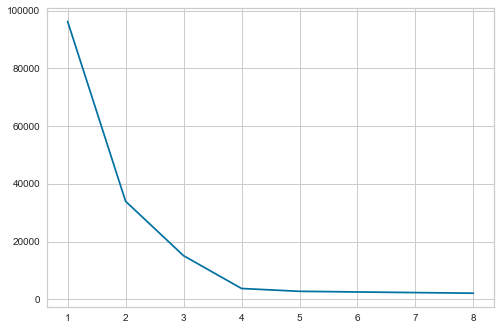

In [356]:
# def elbow_score(points, clusters, centers):
#     sum = 0
#     for point, cluster in zip(points, clusters):
#         center = centers[cluster]
#         sum += (point[0] - center[0])**2 + (point[1] - center[1])**2
#     return sum

scores = []

for clusters in range(1,9):
    model = KMeans(n_clusters=clusters, random_state=1)
    res = model.fit_predict(convex_blobs)
    scores.append(model.inertia_)

plt.plot(range(1,9), scores)